# GP Simulated dataset analysis using G2G - supplementary test

In [12]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import regex as re
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect
import VisualUtils 
import anndata
import time
import scipy.sparse
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 

# new source imports 
import Main 
import ClusterUtils
import SimulationExperimentAnalyser
import warnings
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
anndata.__version__

'0.8.0'

In [13]:
torch.cuda.get_device_name( torch.cuda.current_device())

'Tesla T4'

In [14]:
# Load simulated datasets
drive_dir = '../GOOGLE_DRIVE_MOUNT/OrgAlign/SimulatedData_for_G2G/all_simulated_datasets_07012023/'
with open(drive_dir+'matched_datasets.pkl', 'rb') as f:
    matched_datasets = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.25.pkl', 'rb') as f:
    divergence_simulated_datasets_25 = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.5.pkl', 'rb') as f:
    divergence_simulated_datasets_05 = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.75.pkl', 'rb') as f:
    divergence_simulated_datasets_75 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.25.pkl', 'rb') as f:
    convergence_simulated_datasets_25 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.5.pkl', 'rb') as f:
    convergence_simulated_datasets_05 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.75.pkl', 'rb') as f:
    convergence_simulated_datasets_75 = pickle.load(f)
    
T_f = torch.tensor(np.linspace(0,1,300,dtype=np.float64))  # specify time points 
# ========================================================================= LOADING CP data for DIVERGENCE AND CONVERGENCE 
# To examine the change point branching kernel to determine the approx bifurcation start point and expected range
with open(drive_dir+'/CP_05.pkl', 'rb') as f:
    CP_05 = pickle.load(f)
with open(drive_dir+'/CP_25.pkl', 'rb') as f:
    CP_25 = pickle.load(f)
with open(drive_dir+'/CP_75.pkl', 'rb') as f:
    CP_75 = pickle.load(f)
CP_75 = pd.DataFrame(CP_75.numpy()) 
CP_05 = pd.DataFrame(CP_05.numpy()) 
CP_25 = pd.DataFrame(CP_25.numpy()) 

#plot_simulated_dataset(matched_datasets[0:8],T_f)
# Taking 100 genes from each pattern class
matched_datasets = matched_datasets[0:500]
divergence_simulated_datasets_25 = divergence_simulated_datasets_25[0:500]
divergence_simulated_datasets_05 = divergence_simulated_datasets_05[0:500]
divergence_simulated_datasets_75 = divergence_simulated_datasets_75[0:500]
convergence_simulated_datasets_25 = convergence_simulated_datasets_25[0:500]
convergence_simulated_datasets_05 = convergence_simulated_datasets_05[0:500]
convergence_simulated_datasets_75 = convergence_simulated_datasets_75[0:500]

divergence_simulated_datasets =  divergence_simulated_datasets_05 + divergence_simulated_datasets_25 + divergence_simulated_datasets_75
convergence_simulated_datasets = convergence_simulated_datasets_05 + convergence_simulated_datasets_25 + convergence_simulated_datasets_75
simulated_data = divergence_simulated_datasets + matched_datasets + convergence_simulated_datasets
pattern_labels = list(np.repeat('Divergence_05', len(divergence_simulated_datasets_05))) + list(np.repeat('Divergence_025', len(divergence_simulated_datasets_25))) + list(np.repeat('Divergence_075', len(divergence_simulated_datasets_75))) + list(np.repeat('AllMatch', len(matched_datasets))) + list(np.repeat('Convergence_05', len(convergence_simulated_datasets_05))) + list(np.repeat('Convergence_025', len(convergence_simulated_datasets_25))) + list(np.repeat('Convergence_075', len(convergence_simulated_datasets_75)))# + list(np.repeat('Crossing', len(cross_datasets)))

def convert2adata(simulated_datasets,T_f, tag, write=False):
    # if const_std mode, G2G uses a constant of std=0.1 for all time points 
    n_sim_genes = len(simulated_datasets) 
    r_df = []
    q_df = []
    time = T_f.detach().numpy()
    
    for dataset in simulated_datasets:
        r_df.append( dataset[0])
        q_df.append( dataset[1])
    r_df = pd.DataFrame(r_df).transpose() 
    q_df = pd.DataFrame(q_df).transpose() 
    r_df.columns = np.asarray(['Gene' + str(x) for x in np.arange(n_sim_genes)]) 
    q_df.columns = r_df.columns
    gene_list = list(r_df.columns)

    adata_ref = anndata.AnnData(X=scipy.sparse.csr_matrix((r_df)))
    adata_ref.var_names = r_df.columns
    adata_ref.obs_names = r_df.index
    adata_ref.obs['time'] = time
    adata_query = anndata.AnnData(X=scipy.sparse.csr_matrix(q_df))
    adata_query.var_names = q_df.columns
    adata_query.obs_names = q_df.index
    adata_query.obs['time'] = time
    
    if(write):
        dataset_dir = 'SimulationData/'
        adata_ref.write_h5ad(  dataset_dir   + 'ref_'   + tag+'.h5ad')
        adata_query.write_h5ad(dataset_dir   + 'query_' + tag+'.h5ad')

    return adata_ref, adata_query

def plot_simulated_dataset(simulated_dataset, T_f, figsize = (15,4)):
    l = len(simulated_dataset)
    ncol = 4
    nrow = int(np.ceil(l/ncol)) 
    plt.subplots(nrow,ncol,figsize=figsize) 
    k=1
    for pair in simulated_dataset:
        plt.subplot(nrow,ncol,k)
        sb.scatterplot(x=T_f,y=pair[0], color='midnightblue')
        sb.scatterplot(x=T_f,y=pair[1], color='forestgreen')
        k=k+1
    plt.tight_layout()

def plotTimeSeries(al_obj, refQueryAlignerObj, plot_cells = False, plot_mean_trend= False):
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment(al_obj) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.max(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.min(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=refQueryAlignerObj.query_time, y=np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]), alpha=0.7, color = 'midnightblue', legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([min_val-0.5,max_val+0.5])
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=refQueryAlignerObj.ref_time, y=np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene]), color = 'forestgreen', alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([min_val-0.5,max_val+0.5])
        
def plotTimeSeriesAlignment(al_obj):  
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.plot_mean_trends() 
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=0.6)

In [16]:
def prep(dataset, name, optimal_binning, load_aligner = False):

    adata_ref, adata_query = convert2adata(dataset, T_f, name, write=False)
    adata_ref.obs['class'] = np.asarray( adata_ref.obs['time']*10 , dtype = np.int)
    adata_query.obs['class'] = np.asarray( adata_query.obs['time']*10 , dtype = np.int)
    adata_ref.var['gene_pattern'] = pattern_labels
    adata_query.var['gene_pattern'] = pattern_labels
    
    if(load_aligner):
        with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_all_GP_simulated_data.pkl', 'rb') as f:
            aligner = pickle.load(f)
        return aligner, adata_ref, adata_query 
    
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=15, 
                                        ANNOTATION_COLNAME='class', optimal_binning=False, PLOT=False)
    
    s_time = time.time()
    aligner = run_g2g(adata_ref, adata_query, N_BINS, vs, STATE_PARAMS, optimal_binning=True) 
    print(e_time-s_time)
    #pickle.dump(aligner_all, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_all_GP_simulated_data.pkl', 'wb')) 
    return aligner, adata_ref, adata_query 

N_BINS = 15
STATE_PARAMS = [0.99, 0.1, 0.7]
aligner_all, adata_ref, adata_query  = prep(simulated_data, 'all', optimal_binning=True, load_aligner=True)
genes = adata_ref.var_names
pattern_map = {}
for i in range(len(pattern_labels)):
    pattern_map[genes[i]] = pattern_labels[i]

In [17]:
aligner_all.results[0].S.mean_trend
aligner_all.results[0].T.std_trend

array([0.04704781, 0.08797676, 0.08428727, 0.1127581 , 0.1382875 ,
       0.12965942, 0.11721736, 0.08679577, 0.09546537, 0.09908504,
       0.11417091, 0.13424265, 0.15376771, 0.12015651, 0.06955675])

In [56]:
matched_means = []
matched_variances = []
all_means =[]
all_variances = []

mean_diffs = [] 
std_diffs = []

alignment_costs = []
alignment_percentages = [] 

P1 = []
P2 = []

gene_patterns =[]
for a in tqdm(aligner_all.results):
    

    meansS = [] 
    meansT = [] 
    variancesS = []
    variancesT = []
    
    for t in a.match_points_S:
        meansS.append(a.S.mean_trend[t])
        variancesS.append(a.S.std_trend[t])
        
    for t in a.match_points_T:
        meansT.append(a.T.mean_trend[t])
        variancesT.append(a.T.std_trend[t])
        
    # diffs across matched points only
    for i in range(len(meansS)):
        mean_diffs.append(abs(meansS[i]-meansT[i]))
    for i in range(len(variancesS)):
        std_diffs.append(abs(variancesS[i]-variancesT[i]))
        
   # print(meansS)
   # print(meansT)
    alignment_costs.append(a.fwd_DP.opt_cost)
    alignment_percentages.append(a.match_percentage)
    
    matched_means += meansS
    matched_means += meansT
    
    matched_variances += variancesS
    matched_variances += variancesT
    
    all_means += list(a.S.mean_trend)
    all_means += list(a.T.mean_trend)
    
    all_variances += list(a.S.std_trend)
    all_variances += list(a.T.std_trend)
    
    P1.append(np.mean(a.S.mean_trend))
    P2.append(np.mean(a.T.mean_trend))
    
    gene_patterns.append(pattern_map[a.gene])
    

100%|██████████| 3500/3500 [00:00<00:00, 22741.81it/s]


Text(0, 0.5, 'Alignment similarity %')

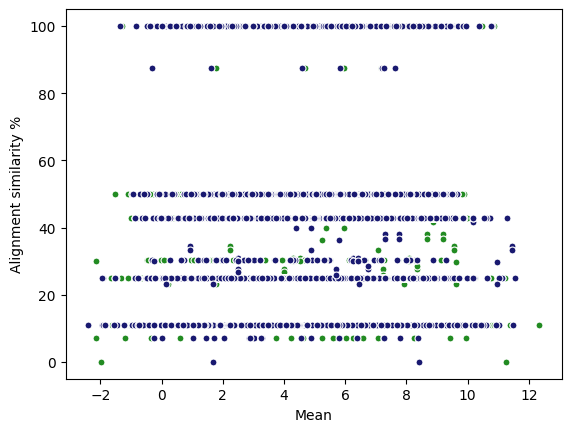

In [29]:
sb.scatterplot(x=P1, y=alignment_percentages, marker='.', color='forestgreen',s=100)
sb.scatterplot(x=P2, y=alignment_percentages, marker='.', color='midnightblue',s=100)
plt.xlabel('Mean')
plt.ylabel('Alignment similarity %')

Text(0, 0.5, 'Alignment similarity %')

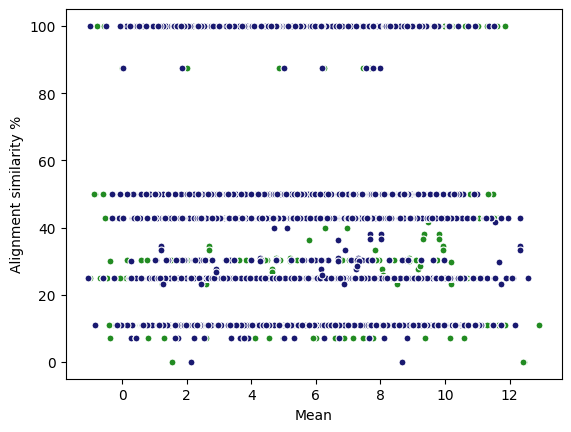

In [27]:
sb.scatterplot(x=P1, y=alignment_percentages, marker='.', color='forestgreen',s=100)
sb.scatterplot(x=P2, y=alignment_percentages, marker='.', color='midnightblue',s=100)
plt.xlabel('Mean')
plt.ylabel('Alignment similarity %')

In [57]:
df = pd.DataFrame([P1,alignment_percentages, gene_patterns]).transpose() 
df.columns = ['Maximum mean', 'Alignment similarity percentage','pattern' ]
df

,Maximum mean,Alignment similarity percentage,pattern
0,6.060797,25.0,Divergence_05
1,0.013413,25.0,Divergence_05
2,8.596374,25.0,Divergence_05
3,1.037549,25.0,Divergence_05
4,-0.14884,25.0,Divergence_05
...,...,...,...
3495,7.423726,11.11,Convergence_075
3496,0.169031,11.11,Convergence_075
3497,7.192905,11.11,Convergence_075
3498,5.234775,11.11,Convergence_075


In [58]:
df['group'] = pd.cut(df['Maximum mean'], bins = [min(df['Maximum mean']), 3, 6, 9, max(df['Maximum mean']),], labels=['<3','3-6','6-9','>9'], include_lowest=True)

In [74]:
#df['pattern'] = [s.split('_')[0] for s in df['pattern']] 

In [82]:
df['pattern'] = df['pattern'].astype('category')
df['pattern']

0         Divergence_05
1         Divergence_05
2         Divergence_05
3         Divergence_05
4         Divergence_05
             ...       
3495    Convergence_075
3496    Convergence_075
3497    Convergence_075
3498    Convergence_075
3499    Convergence_075
Name: pattern, Length: 3500, dtype: category
Categories (7, object): ['AllMatch', 'Convergence_025', 'Convergence_05', 'Convergence_075', 'Divergence_025', 'Divergence_05', 'Divergence_075']

In [ ]:
#for g in aligner_all.gene_list:
 #   if(pattern_map[g] == 'AllMatch'):
  #      print(aligner_all.results_map[g].alignment_str)

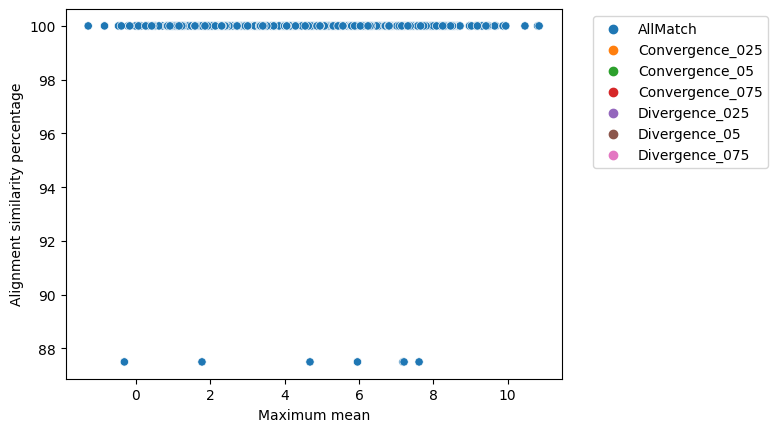

In [92]:
df_sub = df.loc[[p in ['AllMatch'] for p in df['pattern']] ]

ax = sb.scatterplot(data=df_sub, x='Maximum mean',y='Alignment similarity percentage',hue='pattern')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('revision_figs/response3.2_fig_3.png', bbox_inches='tight')

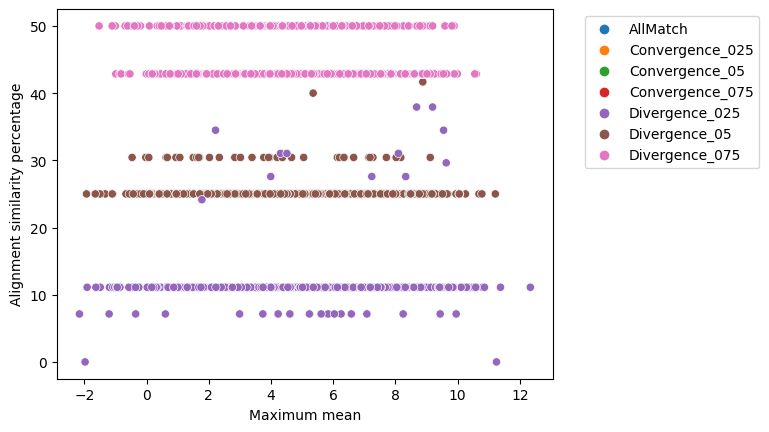

In [91]:
df_sub = df.loc[[p in ['Divergence_025', 'Divergence_05', 'Divergence_075'] for p in df['pattern']] ]
ax = sb.scatterplot(data=df_sub, x='Maximum mean',y='Alignment similarity percentage',hue='pattern')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('revision_figs/response3.2_fig_2.png', bbox_inches='tight')

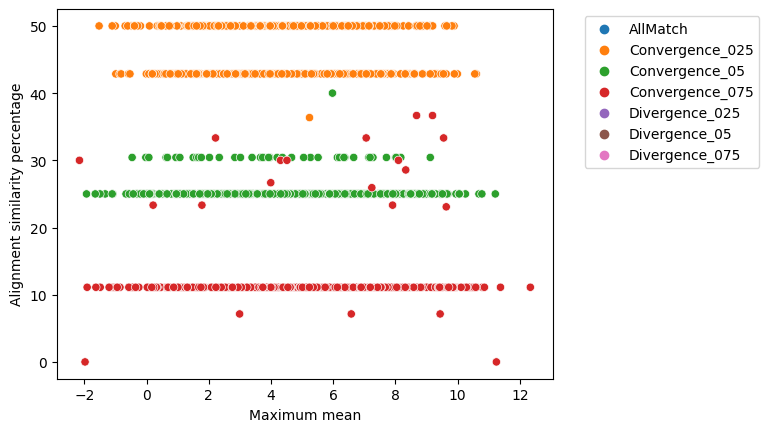

In [89]:
df_sub = df.loc[[p in ['Convergence_025', 'Convergence_05', 'Convergence_075'] for p in df['pattern']] ]

ax = sb.scatterplot(data=df_sub, x='Maximum mean',y='Alignment similarity percentage',hue='pattern')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('revision_figs/response3.2_fig_1.png', bbox_inches='tight')

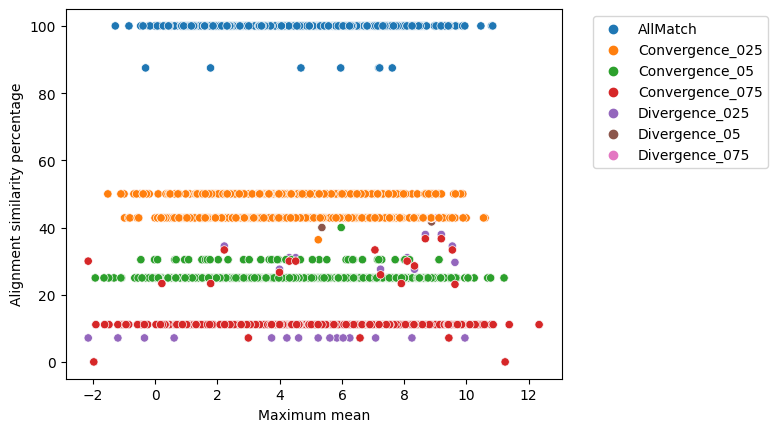

In [90]:

ax = sb.scatterplot(data=df, x='Maximum mean',y='Alignment similarity percentage',hue='pattern')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('revision_figs/response3.2_fig_2.png', bbox_inches='tight')